In this notebook, i tried to predict the open price of Tesla Stock by simple RNN Model and LSTM model.<br>
Those who want to have detailed info on simple RNN and LSTM, may refer to great post below:<br>
http://colah.github.io/posts/2015-08-Understanding-LSTMs/


* [1. Loading Data](#1) <br>
* [2.Spliting Data as Train and Validation](#2) <br>
* [3.Creating Train Dataset from Train split](#3) <br>
* [4.Normalization / Feature Scaling](#4) <br>
* [5.Creating X_train and y_train from Train data](#5) <br>
* [6.Creating Simple RNN model](#6) <br>
* [7.Evaluating Model](#7) <br>
* [8.Creating Test Dataset from Validation Data](#8) <br>
* [9.Evaluating with Validation Data](#9) <br>
* [10.Creating LSTM model](#10) <br>
* [11.Evaluating LSTM model](#11) <br>
* [12.Future price prediction](#12) <br>


<a id="1"></a>
## 1.Loading Data

In [194]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [195]:
data = pd.read_csv("data/VOO_processed.csv")

In [196]:
data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
0,0,2010-09-09,102.500000,102.500000,101.139999,101.320000,78.490952,26500,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,2010-09-10,101.680000,101.860001,101.300003,101.779999,78.847305,8600,NaN,0.010320,0.005734,NaN,NaN,NaN,NaN
2,2,2010-09-13,102.959999,103.139999,102.500000,103.059998,79.838921,33750,NaN,0.052843,0.025041,NaN,NaN,NaN,NaN
3,3,2010-09-14,102.839996,103.480003,102.379997,103.040001,79.823387,59400,NaN,0.070166,0.040327,NaN,NaN,NaN,NaN
4,4,2010-09-15,102.620003,103.379997,102.400002,103.300003,80.024826,9250,NaN,0.088448,0.054642,102.5,NaN,NaN,NaN


In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421 entries, 0 to 3420
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3421 non-null   int64  
 1   Date        3421 non-null   object 
 2   Open        3421 non-null   float64
 3   High        3421 non-null   float64
 4   Low         3421 non-null   float64
 5   Close       3421 non-null   float64
 6   Adj Close   3421 non-null   float64
 7   Volume      3421 non-null   int64  
 8   RSI         3408 non-null   float64
 9   MACD        3421 non-null   float64
 10  Signal      3421 non-null   float64
 11  SMA_5       3417 non-null   float64
 12  SMA_20      3402 non-null   float64
 13  SMA_60      3362 non-null   float64
 14  SMA_120     3302 non-null   float64
dtypes: float64(12), int64(2), object(1)
memory usage: 401.0+ KB


<a id="2"></a>
## 2.Spliting Data as Train and Validation

In [198]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 3421
Train data length : 2395
Validation data lenth : 1026


In [199]:
train_data = data[:length_train]
train_data = data.drop(columns=['Date'])
# train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
0,0,102.500000,102.500000,101.139999,101.320000,78.490952,26500,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,101.680000,101.860001,101.300003,101.779999,78.847305,8600,NaN,0.010320,0.005734,NaN,NaN,NaN,NaN
2,2,102.959999,103.139999,102.500000,103.059998,79.838921,33750,NaN,0.052843,0.025041,NaN,NaN,NaN,NaN
3,3,102.839996,103.480003,102.379997,103.040001,79.823387,59400,NaN,0.070166,0.040327,NaN,NaN,NaN,NaN
4,4,102.620003,103.379997,102.400002,103.300003,80.024826,9250,NaN,0.088448,0.054642,102.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,3416,477.149994,478.070007,475.970001,476.679993,476.679993,4736800,51.799979,2.971678,4.060090,475.787994,476.323001,462.401168,438.519501
3417,3417,478.380005,478.600006,472.739990,477.269989,477.269989,5254200,45.310110,2.812669,3.810606,475.855994,476.686501,463.059167,439.158667
3418,3418,471.910004,474.390015,470.670013,472.649994,472.649994,6933400,35.234176,2.287489,3.505982,474.913995,476.567500,463.636834,439.759251
3419,3419,473.980011,477.429993,470.670013,476.059998,476.059998,5105200,44.918567,2.121978,3.229181,475.829993,476.655000,464.296168,440.432917


In [200]:
validation_data = data[length_train:]
validation_data = data.drop(columns=['Date'])
validation_data

,Unnamed: 0,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,Signal,SMA_5,SMA_20,SMA_60,SMA_120
0,0,102.500000,102.500000,101.139999,101.320000,78.490952,26500,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN
1,1,101.680000,101.860001,101.300003,101.779999,78.847305,8600,NaN,0.010320,0.005734,NaN,NaN,NaN,NaN
2,2,102.959999,103.139999,102.500000,103.059998,79.838921,33750,NaN,0.052843,0.025041,NaN,NaN,NaN,NaN
3,3,102.839996,103.480003,102.379997,103.040001,79.823387,59400,NaN,0.070166,0.040327,NaN,NaN,NaN,NaN
4,4,102.620003,103.379997,102.400002,103.300003,80.024826,9250,NaN,0.088448,0.054642,102.500000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3416,3416,477.149994,478.070007,475.970001,476.679993,476.679993,4736800,51.799979,2.971678,4.060090,475.787994,476.323001,462.401168,438.519501
3417,3417,478.380005,478.600006,472.739990,477.269989,477.269989,5254200,45.310110,2.812669,3.810606,475.855994,476.686501,463.059167,439.158667
3418,3418,471.910004,474.390015,470.670013,472.649994,472.649994,6933400,35.234176,2.287489,3.505982,474.913995,476.567500,463.636834,439.759251
3419,3419,473.980011,477.429993,470.670013,476.059998,476.059998,5105200,44.918567,2.121978,3.229181,475.829993,476.655000,464.296168,440.432917


<a id="3"></a>
## 3.Creating Train Dataset from Train split

* We will get Open column as our dataset
* Dataset to be converted to array by adding `.values`

In [201]:
dataset_train = train_data
dataset_train.shape

(3421, 14)

In [202]:
# Change 1d array to 2d array
# Changing shape from (1692,) to (1692,1)
dataset_train = dataset_train[120:]
dataset_train = dataset_train
dataset_train.shape

(3301, 14)

#### <a id="4"></a>
## 4.Normalization / Feature Scaling

* Dataset values will be in between 0 and 1 after scaling

In [203]:
from sklearn.preprocessing import MinMaxScaler



In [204]:
# plt.subplots(figsize = (15,6))
# plt.plot(dataset_train_scaled)
# plt.xlabel("Days as 1st, 2nd, 3rd..")
# plt.ylabel("Open Price")
# plt.show()

<a id="5"></a>
## 5.Creating X_train and y_train from Train data

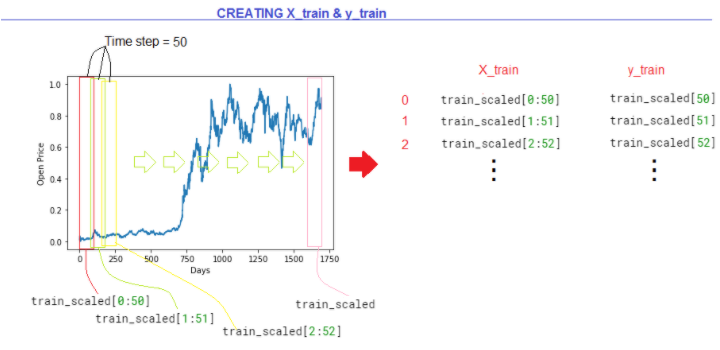

* We have train data composed of stock open prices over days
* So, it has 1184 prices corresponding 1184 days
* My aim is to predict the open price of the next day.
* I can use a time step of 50 days.
* I will pick first 50 open prices (0 to 50), 1st 50 price will be in X_train data
* Then predict the price of 51th day; and 51th price will be in y_train data
* Again, i will pick prices from 1 to 51, those will be in X_train data
* Then predict the next days price, 52nd price will be in y_train data

In [205]:
X_train = []
y_train = []

time_step = 10
input_scaler = MinMaxScaler(feature_range = (0,1))
output_scaler = MinMaxScaler(feature_range = (0,1))

dataset_train = input_scaler.fit_transform(np.array(dataset_train))
dataset_y = output_scaler.fit_transform(np.array(dataset_train[:,4]).reshape(-1, 1))

for i in range(time_step, len(dataset_train)):
    X_train.append(dataset_train[i-time_step:i,:])
    y_train.append(dataset_y[i])

# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)


In [206]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (3291, 10, 14)
Shape of y_train before reshape : (3291, 1)


## Reshape

In [207]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 14))
y_train = np.reshape(y_train, (y_train.shape[0], 1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (3291, 10, 14)
Shape of y_train after reshape : (3291, 1)


* Shape of X_train : 1134 x 50 x 1
* That means we have 1134 rows, each row has 50 rows and 1 column
* Lets check the first row: it has 50 rows (open prices of 49 days)

In [208]:
X_train[2]

array([[6.06060606e-04, 5.97684323e-02, 5.05756752e-02, 5.78635508e-02,
        5.47492194e-02, 3.77538241e-02, 5.19307563e-03, 4.64725339e-01,
        7.41080822e-01, 7.42444225e-01, 4.67257356e-02, 3.96548049e-02,
        2.70808219e-02, 4.46736678e-03],
       [9.09090909e-04, 5.85688936e-02, 4.97345004e-02, 5.57746063e-02,
        5.19671466e-02, 3.56857911e-02, 4.66321138e-03, 4.41429680e-01,
        7.37279795e-01, 7.39861252e-01, 4.58529545e-02, 3.96791181e-02,
        2.74285273e-02, 4.89959477e-03],
       [1.21212121e-03, 5.54918093e-02, 4.94190724e-02, 5.67146293e-02,
        5.49067092e-02, 3.78708326e-02, 2.67977319e-03, 4.56339137e-01,
        7.37027221e-01, 7.37735449e-01, 4.66831640e-02, 3.97520578e-02,
        2.78089468e-02, 5.35356057e-03],
       [1.51515152e-03, 5.71607344e-02, 4.87881763e-02, 5.81246638e-02,
        5.45392664e-02, 3.75977429e-02, 3.08985970e-03, 4.31034566e-01,
        7.36261183e-01, 7.35854578e-01, 4.72579235e-02, 3.97304466e-02,
        2.815

* Check the first item in y_train
* It is the price of 50th day

In [209]:
y_train

array([[0.03963152],
       [0.04341094],
       [0.04472324],
       ...,
       [0.97716592],
       [0.98611583],
       [0.96734993]])

<a id="6"></a>
## 6.Creating RNN model 

In [210]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1], 14))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error")

# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3832
Epoch 2/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1478
Epoch 3/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0882
Epoch 4/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0579
Epoch 5/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0416
Epoch 6/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0294
Epoch 7/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0234
Epoch 8/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0177
Epoch 9/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0146
Epoch 10/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0123
Epoch 11/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0102
Epoch 12/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086
Epoch 13/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0068
Epoch 14/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0063
Epoch 15/100
103/103 ━━━━━━━━━━━━━━━━━━━━ 1

In [211]:
y_pred = regressor.predict(X_train)
y_pred

103/103 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


array([[0.0433861 ],
       [0.0425165 ],
       [0.04200339],
       ...,
       [0.9296093 ],
       [0.92948437],
       [0.9293803 ]], dtype=float32)

<a id="7"></a>
## 7.Evaluating Model

In [212]:
# Losses
history.history["loss"]

[0.29522421956062317,
 0.130707249045372,
 0.0773620679974556,
 0.05235952138900757,
 0.037945691496133804,
 0.028939098119735718,
 0.02216974087059498,
 0.01727326400578022,
 0.013920646160840988,
 0.011467880569398403,
 0.009792705997824669,
 0.008030829019844532,
 0.006687130779027939,
 0.006305302958935499,
 0.005622882395982742,
 0.004716544412076473,
 0.004643624648451805,
 0.004117355216294527,
 0.0038938778452575207,
 0.0038034406024962664,
 0.003533785929903388,
 0.0032786254305392504,
 0.0032959335949271917,
 0.0030259753111749887,
 0.002986706094816327,
 0.0029544620774686337,
 0.002738801296800375,
 0.0025566737167537212,
 0.0025729029439389706,
 0.0024177671875804663,
 0.0024224722292274237,
 0.0023990061599761248,
 0.0022359814029186964,
 0.0022042258642613888,
 0.0021876594983041286,
 0.002036669524386525,
 0.002048118971288204,
 0.0019764243625104427,
 0.0018990251701325178,
 0.0019480693154036999,
 0.0018486484186723828,
 0.0017239421140402555,
 0.0017384957754984498,


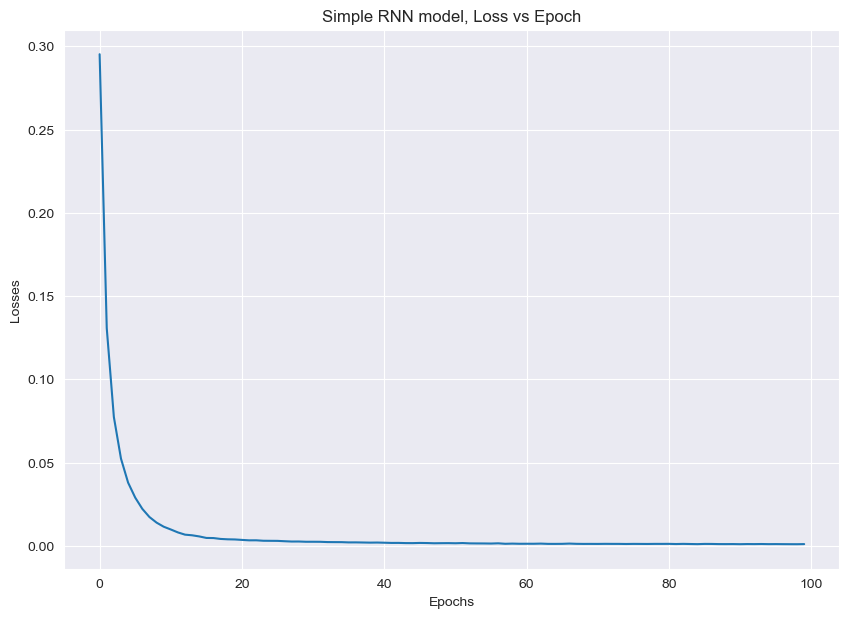

In [213]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [214]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

KeyError: 'accuracy'

<Figure size 1000x500 with 0 Axes>

## Model predictions for train data 

In [215]:
y_pred = regressor.predict(X_train)  # predictions
print(y_pred)
y_pred = output_scaler.inverse_transform(y_pred) # scaling back from 0-1 to original
y_pred.shape

103/103 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
[[0.0433861 ]
 [0.0425165 ]
 [0.04200339]
 ...
 [0.9296093 ]
 [0.92948437]
 [0.9293803 ]]


(3291, 1)

In [216]:
y_train = output_scaler.inverse_transform(y_train) # scaling back from 0-1 to original
y_train.shape

(3291, 1)

In [217]:
y_train

array([[0.03963152],
       [0.04341094],
       [0.04472324],
       ...,
       [0.97716592],
       [0.98611583],
       [0.96734993]])

In [218]:
y_pred

array([[0.0433861 ],
       [0.0425165 ],
       [0.04200339],
       ...,
       [0.9296093 ],
       [0.92948437],
       [0.9293803 ]], dtype=float32)

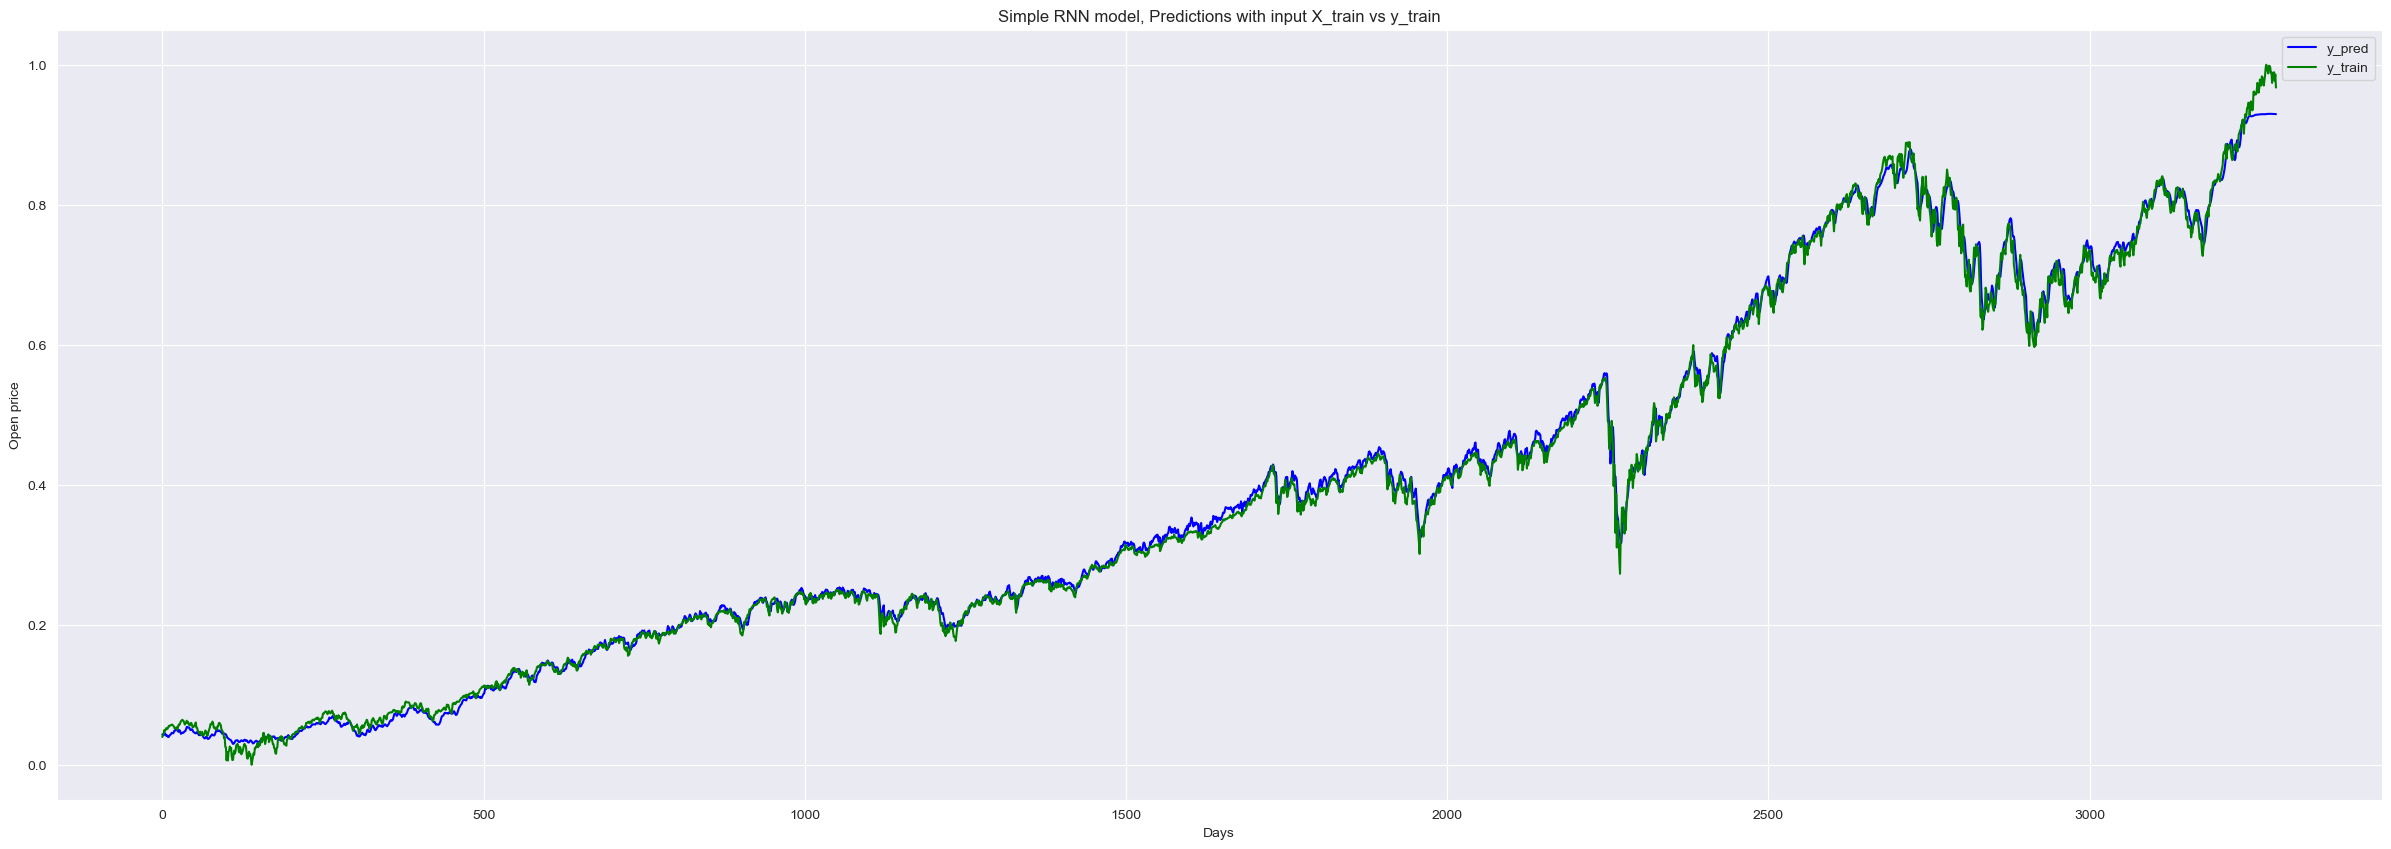

In [219]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred, color = "b", label = "y_pred" )
plt.plot(y_train, color = "g", label = "y_train")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Predictions with input X_train vs y_train")
plt.legend()
plt.show()


<a id="8"></a>
## 8.Creating Test Dataset from Validation Data 

### Converting array and scaling

In [ ]:
dataset_validation = validation_data  # getting "open" column and converting to array
dataset_validation = dataset_validation  # converting 1D to 2D array
scaled_dataset_validation =  scaler.fit_transform(dataset_validation)  # scaling open values to between 0 and 1
print("Shape of scaled validation dataset :",scaled_dataset_validation.shape)

### Creating X_test and y_test

### Converting to array

In [ ]:
# Converting to array
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
print("Shape of X_test before reshape :",X_test.shape)
print("Shape of y_test before reshape :",y_test.shape)

### Reshape

In [ ]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))  # reshape to 3D array
y_test = np.reshape(y_test, (-1,1))  # reshape to 2D array

In [ ]:
print("Shape of X_test after reshape :",X_test.shape)
print("Shape of y_test after reshape :",y_test.shape)

<a id="9"></a>
## 9.Evaluating with Validation Data 

In [ ]:
# predictions with X_test data
y_pred_of_test = regressor.predict(X_test)
# scaling back from 0-1 to original
y_pred_of_test = scaler.inverse_transform(y_pred_of_test) 
print("Shape of y_pred_of_test :",y_pred_of_test.shape)

In [ ]:
# visualisation
plt.figure(figsize = (30,10))
plt.plot(y_pred_of_test, label = "y_pred_of_test", c = "orange")
plt.plot(scaler.inverse_transform(y_test), label = "y_test", c = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Prediction with input X_test vs y_test")
plt.legend()
plt.show()

In [ ]:
# Visualisation
plt.subplots(figsize =(30,12))
plt.plot(train_data.Date, train_data.Open, label = "train_data", color = "b")
plt.plot(validation_data.Date, validation_data.Open, label = "validation_data", color = "g")
plt.plot(train_data.Date.iloc[time_step:], y_pred, label = "y_pred", color = "r")
plt.plot(validation_data.Date.iloc[time_step:], y_pred_of_test, label = "y_pred_of_test", color = "orange")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("Simple RNN model, Train-Validation-Prediction")
plt.legend()
plt.show()

<a id="10"></a>
## 10.Creating LSTM Model

In [ ]:
y_train = scaler.fit_transform(y_train)

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(
    LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1))) #64 lstm neuron block
model_lstm.add(
    LSTM(64, return_sequences= False))
model_lstm.add(Dense(32))
model_lstm.add(Dense(1))
model_lstm.compile(loss = "mean_squared_error", optimizer = "adam", metrics = ["accuracy"])
history2 = model_lstm.fit(X_train, y_train, epochs = 10, batch_size = 10)


<a id="11"></a>
## 11.Evaluating LSTM Model

In [ ]:
plt.figure(figsize =(10,5))
plt.plot(history2.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

In [ ]:
plt.subplots(figsize =(30,12))
plt.plot(scaler.inverse_transform(model_lstm.predict(X_test)), label = "y_pred_of_test", c = "orange" )
plt.plot(scaler.inverse_transform(y_test), label = "y_test", color = "g")
plt.xlabel("Days")
plt.ylabel("Open price")
plt.title("LSTM model, Predictions with input X_test vs y_test")
plt.legend()
plt.show()

<a id="12"></a>
## 12.Future price prediction

* Which day is the last day in our data?

In [ ]:
data.iloc[-1]

* We can predict the open price for the day after 3/17/2017--> for  3/18/2017.
* We will use last 50 days Open price as input of our model for this prediction
* Let us prepare it:

In [ ]:
X_input = data.iloc[-time_step:].Open.values               # getting last 50 rows and converting to array
X_input = scaler.fit_transform(X_input.reshape(-1,1))      # converting to 2D array and scaling
X_input = np.reshape(X_input, (1,50,1))                    # reshaping : converting to 3D array
print("Shape of X_input :", X_input.shape)
X_input

In [ ]:
simple_RNN_prediction = scaler.inverse_transform(regressor.predict(X_input))
LSTM_prediction = scaler.inverse_transform(model_lstm.predict(X_input))
print("Simple RNN, Open price prediction for 3/18/2017      :", simple_RNN_prediction[0,0])
print("LSTM prediction, Open price prediction for 3/18/2017 :", LSTM_prediction[0,0])

## Thanks for reading, please upvote:)